# Image Super Resolution using ESRGAN

---

## Technical information
- Candidate: Claudia Maria Moncada Da Silva
- Creation date: 2024-05-22

## Objectives
Implement an upscaling algorithm that improves the resolution of a set of images obtained from the OpenStreetView API.

## Summary
This notebook was developed to implement the upscaling algorithm. The framework used is TensorFlow in a Google Colab environment. The model used is ESRGAN which is available from https://www.tensorflow.org/hub/tutorials/image_enhancing. The dataset used was the one provided in the following Github repository https://github.com/DiversaStudio/Test.git.

## Results
- For each image of the original dataset, the ESRGAN model was applied to obtain its corresponding image in better quality.
- Metrics such as PSNR and SSIM are provided to evaluate the quality of the images generated at high resolution.

## Change log:
- 2024-05-22 Initial notebook creation (claudia.moncada@yachaytech.edu.ec)



Algorithm selection: The ESRGAN algorithm preserves detail and visual quality through its ability to learn complex patterns. It uses a generative model, which helps to capture finer details in images, resulting in higher visual quality results. This also helps to contain realistic details, which is useful in a diverse number of applications and scenarios.

### Libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import cv2
import random
from skimage.metrics import structural_similarity as compare_ssim
%matplotlib inline
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

### Download the set of images

The images are contained in the `data` folder.  

In [ ]:
!git clone https://github.com/DiversaStudio/Test.git

Cloning into 'Test'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (78/78), 19.59 MiB | 14.31 MiB/s, done.


### Declaring general variables

In [ ]:
#image_path = "/content/Test/data" #Path of original images
path_original_images_folder = '/content/Test/data' #Path to the original images
path_sr_images_folder = "/content/imagenes_sr/" #Path to save the images in SR

SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1" #Pretrained model ESRGAN

## Defining helper functions

### Define the function preprocess_image

The configuration for the application of the ESRGAN model has special features for its operation. At this stage the original images are preprocessed to meet the requirements of the model.

In [ ]:
def preprocess_image(image_path):
    """ Loads image from path and preprocesses to make it model ready
        Args:
          image_path: Path to the image file
    """
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # remove the alpha channel, the model only supports images with 3 color channels (RGB).
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4 #Adjusts image dimensions to be multiples of 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32) #Converts the image to the tf.float32 data type
    return tf.expand_dims(hr_image, 0)

### Define the function save_image

In [ ]:
def save_image(image, filename, output_folder):
    """
      Saves unscaled Tensor Images.
      Args:
        image: 3D image tensor. [height, width, channels]
        filename: Name of the file to save.
        output_folder: Folder to save the image.
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy()) #Converts the image tensor to an 8-bit unsigned integer array and then to a PIL image.
    print(f'image path: {os.path.join(output_folder, "%s.jpg" % filename)}')
    image.save(os.path.join(output_folder, "%s.jpg" % filename))
    print("Saved as %s.jpg" % filename)

## Performing ESRGAN of images loaded from path

The original images will be selected and subjected to a preprocessing phase. This stage is necessary to fit the parameters of the model. Subsequently, the ESRGAN model will be applied to these preprocessed images to obtain the super resolution images that will be stored in the folder `imagenes_sr`.

In [ ]:
# 1. Get list of images stored in input folder

input_imagenes_list = os.listdir(path_original_images_folder) #Listing

# Create folder if it does not exists

if not os.path.exists(path_sr_images_folder):
  os.makedirs(path_sr_images_folder)

# 2. Load the model

model = hub.load(SAVED_MODEL_PATH)

# 3. Iterate over the list of images to apply the super resolution model and save each result image in the output folder path

for image in input_imagenes_list:

  # Open the image
  image_path = os.path.join(path_original_images_folder, image) # define the path to each individual image

  hr_image = preprocess_image(image_path) # open the image and apply the func preprocess_image

  fake_image = model(hr_image) # apply the model and obtain the resulting image
  fake_image = tf.squeeze(fake_image)

  result_image_name = image.split(".")[0] + "_sr" #name of the images

  save_image(tf.squeeze(fake_image), filename=result_image_name, output_folder = path_sr_images_folder) # save the final image


# Print the list of resulting images
print(os.listdir(path_sr_images_folder))

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB

image path: /content/imagenes_sr/streetview_49_180_sr.jpg
Saved as streetview_49_180_sr.jpg
image path: /content/imagenes_sr/streetview_48_270_sr.jpg
Saved as streetview_48_270_sr.jpg
image path: /content/imagenes_sr/streetview_53_90_sr.jpg
Saved as streetview_53_90_sr.jpg
image path: /content/imagenes_sr/streetview_51_270_sr.jpg
Saved as streetview_51_270_sr.jpg
image path: /content/imagenes_sr/streetview_52_180_sr.jpg
Saved as streetview_52_180_sr.jpg
image path: /content/imagenes_sr/streetview_50_90_sr.jpg
Saved as streetview_50_90_sr.jpg
image path: /content/imagenes_sr/streetview_55_90_sr.jpg
Saved as streetview_55_90_sr.jpg
image path: /content/imagenes_sr/streetview_57_270_sr.jpg
Saved as streetview_57_270_sr.jpg
image path: /content/imagenes_sr/streetview_55_180_sr.jpg
Saved as streetview_55_180_sr.jpg
image path: /content/imagenes_sr/streetview_55_270_sr.jpg
Saved as streetview_55_270_sr.jpg
image pat

## Evaluation of the model

### Calculate PSNR and SSIM

- These metrics were selected to complement the model evaluation. On the one hand, the PSNR helps to calculate how much noise exists in the processed image with respect to the original one respect of the quadratic error in term of decibels. According to preliminary research, values above 20 dB are optimal values for the PSRN result because it indicates that the output signal is very similar to the original signal.

- On the other hand, the SSIM helps to compare in terms of similarity of brightness, contrast and structure of the images. The values for this metric are in the range of -1 and 1. Values close to -1 mean a minor improvement over the original image, and values close to 1 are the most optimal since they represent a considerable improvement.

In [ ]:
# Function for PSNR y SSIM
def calcular_metricas(img1, img2):
    """
      Calculates PSNR and SSIM for the images
      Args:
        img1 = original image
        img2 = SR image
    """
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)

    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Calculate PSNR
    mse = np.mean((img1 - img2) ** 2) #Squares the pixel-to-pixel differences.
    if mse == 0: #Means the two images are identical
        return float('inf')

    # Calculate PSNR
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    # Calculate SSIM
    ssim = compare_ssim(img1, img2, multichannel=True) #Indicates that the images have multiple channels

    return psnr, ssim

In [ ]:
# List of images
archivos_originales = os.listdir(path_original_images_folder) #list with the names of the entry in the directory of original images
archivos_superresolucion = os.listdir(path_sr_images_folder) #list with the names of the entry in the directory of SR images

archivos_originales.sort() #Sort the images to obtain a coincidence in the index of each original and SR images
archivos_superresolucion.sort()

## Show batch of 5 random examples

<ipython-input-7-5d568704e83b>:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = compare_ssim(img1, img2, multichannel=True)


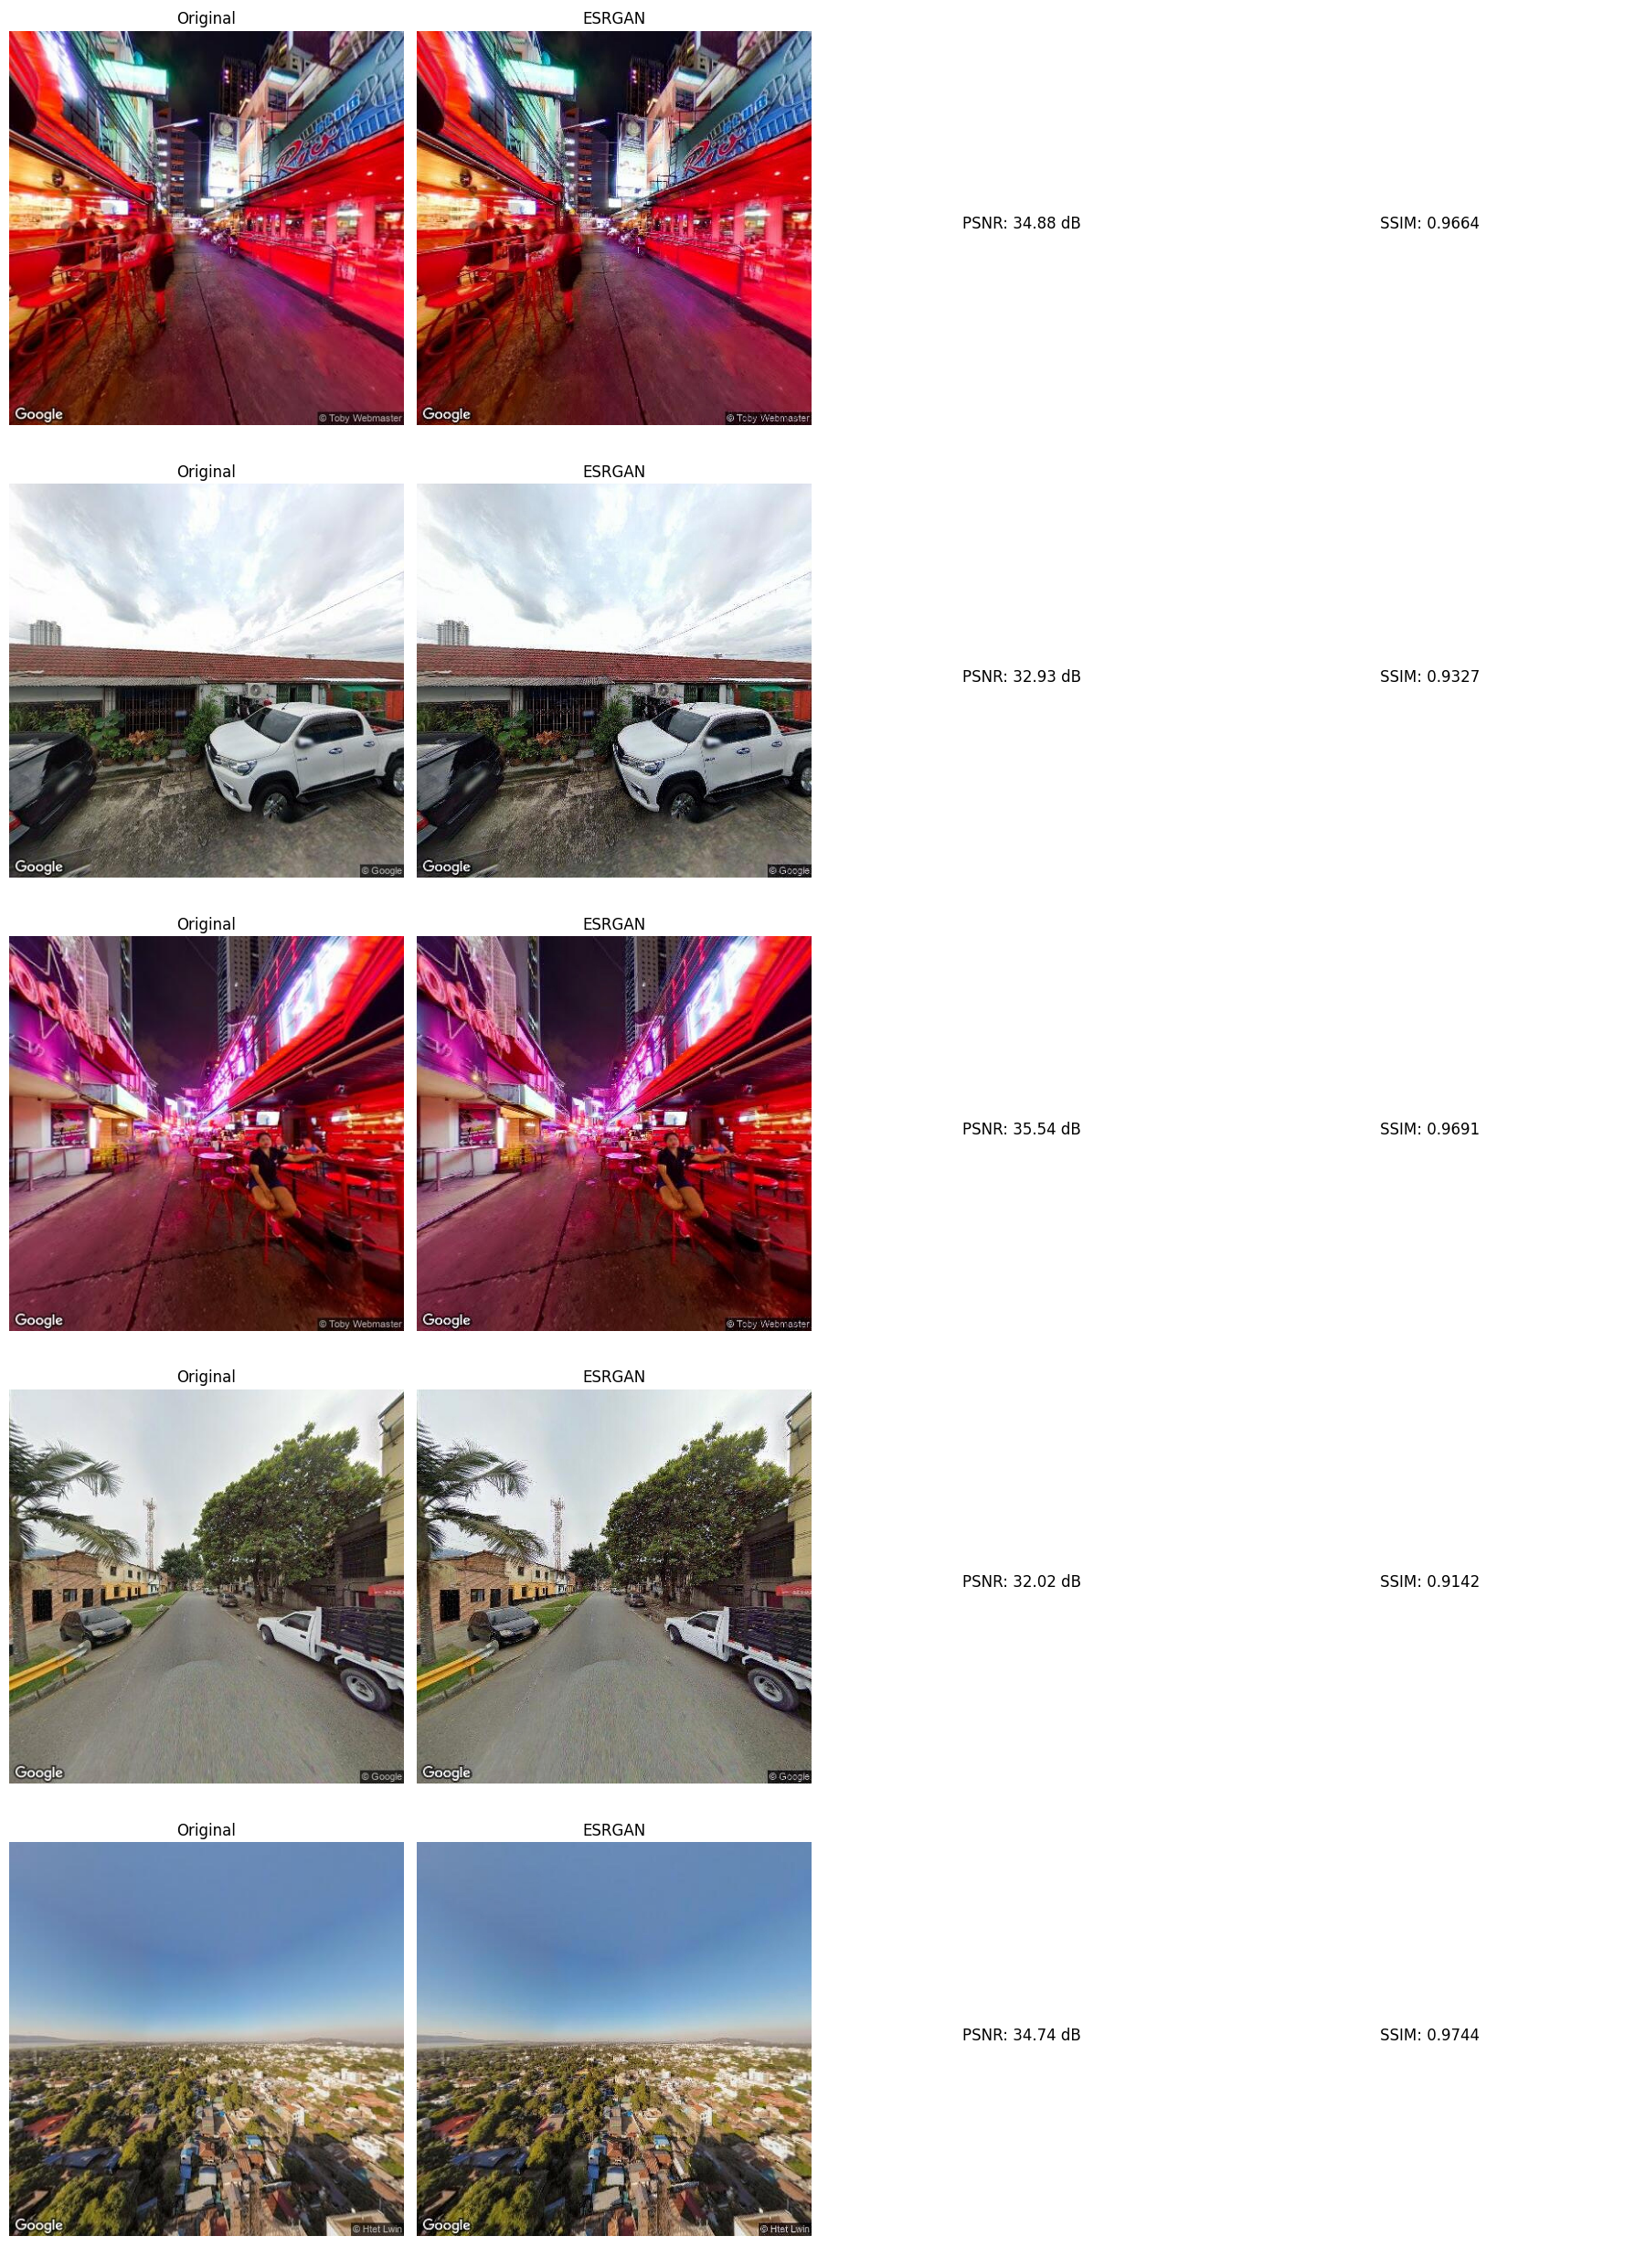

In [ ]:
# Show bath of examples
num_ejemplos = 5  # Number of examples
indices_aleatorios = random.sample(range(len(archivos_originales)), num_ejemplos) #Select random indices for the images

fig, axs = plt.subplots(num_ejemplos, 4, figsize=(18, 5*num_ejemplos)) #Create a figure with multiple subgraphs

for i, indice in enumerate(indices_aleatorios):

    archivo_original = os.path.join(path_original_images_folder, archivos_originales[indice]) #Assigns the full path to the original image file with the corresponding index
    archivo_superresolucion = os.path.join(path_sr_images_folder, archivos_superresolucion[indice]) #Assigns the full path to the SR image file with the corresponding index

    psnr, ssim = calcular_metricas(archivo_original, archivo_superresolucion) #Calculate the metrics for the images

    img_original = cv2.imread(archivo_original) #Read the original image
    img_superresolucion = cv2.imread(archivo_superresolucion) #Read the SR image


    img_superresolucion = cv2.resize(img_superresolucion, (img_original.shape[1], img_original.shape[0]))
    #Resize the SR image to obtain the same size of the original image

    #Plot set of images
    axs[i, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)) #Plot the original image
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(cv2.cvtColor(img_superresolucion, cv2.COLOR_BGR2RGB)) #Plot the corresponding SR image
    axs[i, 1].set_title('ESRGAN')
    axs[i, 1].axis('off')

    # Show PSNR y SSIM for each image
    axs[i, 2].text(0.5, 0.5, f'PSNR: {psnr:.2f} dB', ha='center', fontsize=12) #Show both metrics for the images
    axs[i, 2].axis('off')
    axs[i, 3].text(0.5, 0.5, f'SSIM: {ssim:.4f}', ha='center', fontsize=12)
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()